In [1]:
!brew install libomp
!pip install "u8darts[all]"

/bin/bash: brew: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.0/694.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
!pip install darts
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 11.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [136]:
df = pd.read_csv("CAISO_NORTH_2021-12_MOER.csv")
from datetime import datetime

In [137]:
df_indexed = df[["timestamp", 'MOER']]
df_indexed['timestamp'] = df_indexed['timestamp'].apply(lambda x: x.split('+')[0])
# ar=df_indexed.loc[df['MOER']<750]
#df_indexed[df_indexed['MOER']<750] = int(df_indexed['MOER'].median())
# df_indexed.loc[df_indexed['MOER'] < 750, 'MOER'] = 983
df_indexed.tail(10)

,timestamp,MOER
8918,2021-12-31T23:10:00,49
8919,2021-12-31T23:15:00,46
8920,2021-12-31T23:20:00,45
8921,2021-12-31T23:25:00,877
8922,2021-12-31T23:30:00,939
8923,2021-12-31T23:35:00,1039
8924,2021-12-31T23:40:00,1072
8925,2021-12-31T23:45:00,1071
8926,2021-12-31T23:50:00,1080
8927,2021-12-31T23:55:00,1078


In [138]:
import torch.optim as optim
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
FC_N = 288              # forecast periods
FC_STRIDE = 10
FC_START = "2021-12-25T00:00:00"   # period at which to split training and validation dataset
EPOCH = 5

ts = TimeSeries.from_dataframe(df_indexed,time_col='timestamp',value_cols= 'MOER',fill_missing_dates=True, freq='5T')
series = ts
df = ts.pd_dataframe()

## load data

series = ts  
df = ts.pd_dataframe()

train, val = ts.split_after(pd.Timestamp(FC_START))

# analyze its seasonality
is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (min)":f'{periodicity:.1f}', 
    "periodicity (~hours)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]


is seasonal? : True
periodicity (min) : 46.0
periodicity (~hours) : 3.8


In [139]:
#Scale

trf = Scaler()

#fit the tranform model
train_trf = trf.fit_transform(train)

# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

# create day and month covariate series

month_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=15000),
        attribute='minute', 
    one_hot=False)
month_series = Scaler().fit_transform(month_series)

day_series = datetime_attribute_timeseries(
    month_series,
    attribute='hour', 
    one_hot=True)

covariates = month_series.stack(day_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('2021-12-25 00:00:00'))

# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy



beginning the training of the LSTM RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 80.39 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 35.6816
RMSPE : inf
RMSE : 0.2951
-R squared : 6.5145
se : 0.5433


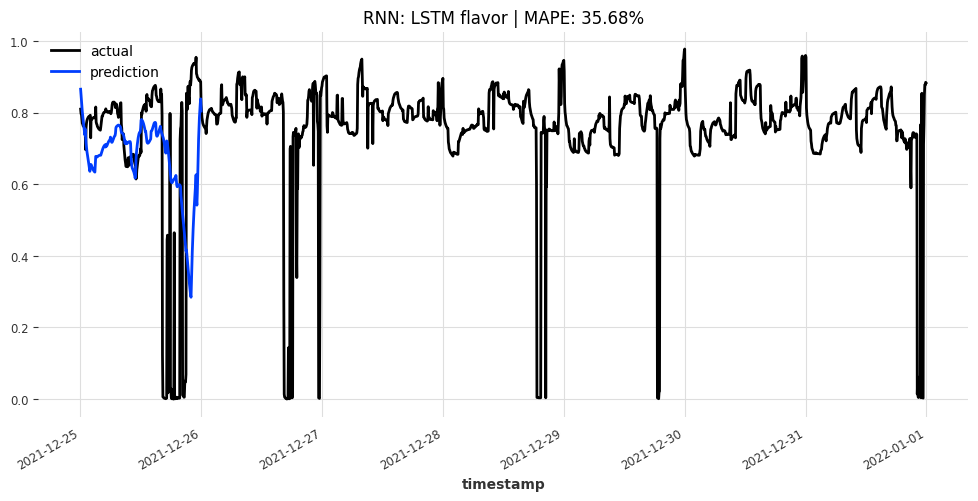

In [140]:
def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

def run_RNN(flavor, ts, train, val):

    # set the model up
    global model_RNN
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    global pred
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, val, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

#Setup and run RNN models

# run 3 different flavors of RNN on the time series:
#flavors = ["LSTM", "GRU", "RNN"]
flavors = ['LSTM']

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]


In [141]:
pred = trf.inverse_transform(pred)
values_array = pred.values()
values_list = values_array.tolist()
val=[]
for i in values_list:
  val.append(i[0])

In [142]:
import pandas as pd
import xarray as xr

# create sample data
timestamps = pd.date_range(start='2021-12-25', periods=288, freq='5min')
values = []
for i in range (288):
  values.append(i)
pred2 = xr.DataArray(values, coords=[timestamps], dims=['time'])

# convert to pandas DataFrame
df2 = pred2.to_dataframe(name='value').reset_index()
df2["pred"]=val
df3 = df2.drop(columns=["value"])
df3

,time,pred
0,2021-12-25 00:00:00,1057.332468
1,2021-12-25 00:05:00,1038.672183
2,2021-12-25 00:10:00,1017.119506
3,2021-12-25 00:15:00,999.043981
4,2021-12-25 00:20:00,983.591045
...,...,...
283,2021-12-25 23:35:00,965.268972
284,2021-12-25 23:40:00,990.300500
285,2021-12-25 23:45:00,1010.129851
286,2021-12-25 23:50:00,1025.758543


In [150]:
df4 = df_indexed['MOER']
dff=df4.loc[6912:7199]
dfff=dff.reset_index()
merged_df = pd.merge(df3, dfff, left_index=True, right_index=True)
df_pred = merged_df.drop(columns=["index"])
df_pred = df_pred.rename(columns={'MOER': 'real'})
df_pred['pred'] = df_pred['pred'].round().astype("int")
df_pred

,time,pred,real
0,2021-12-25 00:00:00,1057,1067
1,2021-12-25 00:05:00,1039,992
2,2021-12-25 00:10:00,1017,977
3,2021-12-25 00:15:00,999,974
4,2021-12-25 00:20:00,984,960
...,...,...,...
283,2021-12-25 23:35:00,965,1086
284,2021-12-25 23:40:00,990,1088
285,2021-12-25 23:45:00,1010,1087
286,2021-12-25 23:50:00,1026,1083


In [152]:
df_pred.to_csv('pred_december.csv', index=False)

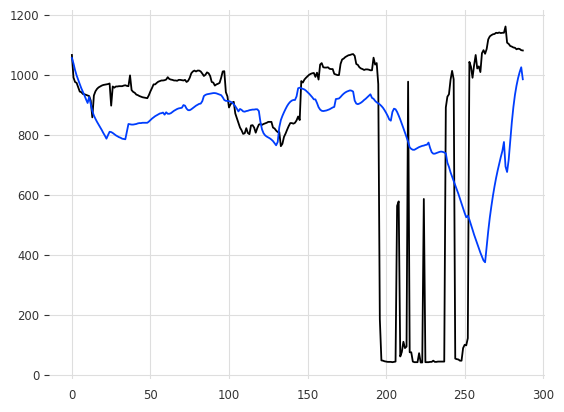

In [151]:
plt.plot(df_pred['real'])
plt.plot(df_pred['pred'])


beginning the training of the LSTM RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 56.67 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 23.3778
RMSPE : 0.5162
RMSE : 0.1277
-R squared : 1.0037
se : 0.3557

beginning the training of the Vanilla RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the Vanilla RNN has completed: 46.10 sec


Predicting: 0it [00:00, ?it/s]

Vanilla : 
MAPE : 22.6992
RMSPE : 0.6740
RMSE : 0.1508
-R squared : 3.3046
se : 0.3632

beginning the training of the GRU RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the GRU RNN has completed: 56.24 sec


Predicting: 0it [00:00, ?it/s]

GRU : 
MAPE : 20.8379
RMSPE : 0.6876
RMSE : 0.1371
-R squared : 2.0143
se : 0.3549


ValueError: ignored

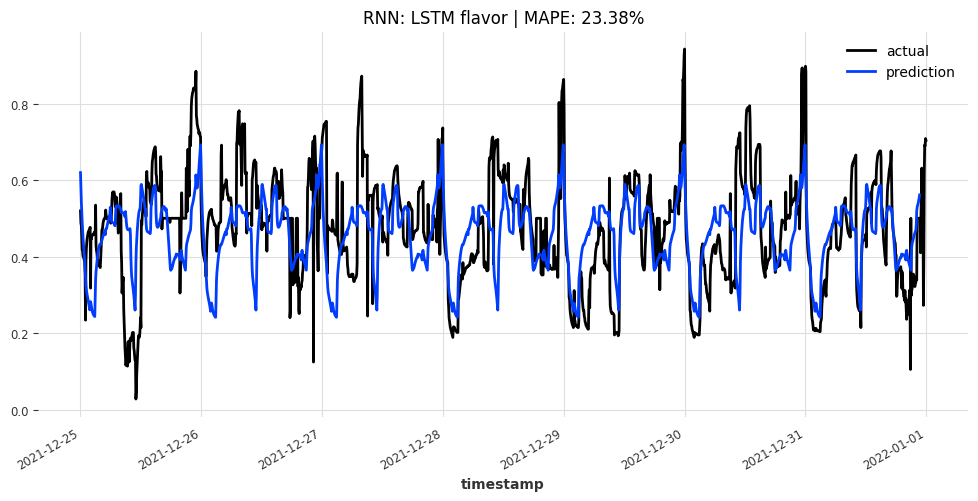

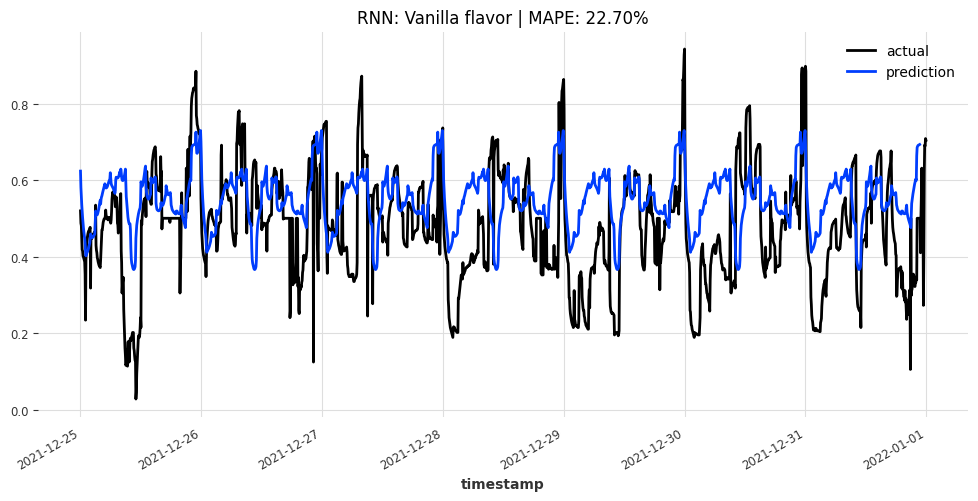

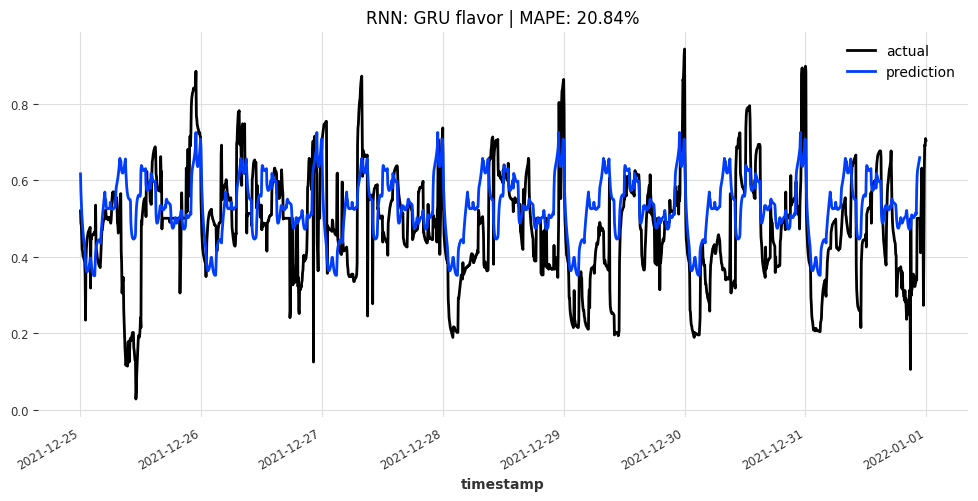

In [ ]:
def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

def run_RNN(flavor, ts, train, val):

    # set the model up
    global model_RNN
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    global pred
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, val, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

#Setup and run RNN models

# run 3 different flavors of RNN on the time series:
#flavors = ["LSTM", "GRU", "RNN"]
flavors = ['LSTM', 'RNN', 'GRU', 'ARIMA']

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]
